In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import sys
import itertools
sys.path.append('src/')
import nn
import process_data
import nibabel as nib
from math import floor, ceil
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure, data
from skimage.io import imread, imsave
import pipeline
import Unet

In [172]:
def elastic_transform(image, alpha, sigma, rand_arr1, rand_arr2, int_order):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    shape = image.shape

#     dx = 0
#     dy = 0
    dx = gaussian_filter((rand_arr1 * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((rand_arr2 * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=int_order).reshape(shape)

In [4]:
def restore_valid_labels(cross_section, true_labels):
    scaled_labels = true_labels * 10
    restored_cross_section = np.empty_like(cross_section)
    for i in range(cross_section.shape[0]):
        for j in range(cross_section.shape[1]):
            scaled_val = cross_section[i][j]
            restored_cross_section[i][j] = get_closest_value(scaled_val, scaled_labels)
            restored_cross_section[i][j] = restored_cross_section[i][j] // 10
    return restored_cross_section

In [139]:
def restore_valid_labels_subs(cross_section, true_labels):
    restored_cross_section = np.empty_like(cross_section)
    for i in range(cross_section.shape[0]):
        for j in range(cross_section.shape[1]):
            orig_val = cross_section[i][j]
            restored_cross_section[i][j] = get_closest_value(orig_val, np.asarray(true_labels))
    return restored_cross_section

In [6]:
def get_closest_value(target, values):
    # type(values) is numpy.ndarray
    idx = (np.abs(values - target)).argmin()
    return values[idx]

In [134]:
all_orig_labels = [0, 7, 8, 9, 45, 51, 52, 53, 68]
forward = {0: 0, 7: 50, 8: 1000, 9: 5000, 45: 400, 51: 500, 52: 600, 53: 700, 68: 800}
inverse = {0: 0, 50: 7, 1000: 8, 5000: 9, 400: 45, 500: 51, 600: 52, 700: 53, 800: 68}

def spread_compress_labels(cross_section, mode):
    if mode == 'spread':
        return np.asarray([forward[i] for i in cross_section.flatten()]).reshape(cross_section.shape)
    elif mode == 'compress':
        return np.asarray([inverse[i] for i in cross_section.flatten()]).reshape(cross_section.shape)
    else:
        return None

In [11]:
nii_data_dir = "/Users/nozik/Documents/HARTresearch/allrawfillednifti"
nii_vol_name = "trial8_30_fs_proc_filled_volume.nii"
nii_seg_name = "trial8_30_fs_proc_filled_seg.nii"

In [12]:
nii_vol = nib.load(os.path.join(nii_data_dir, nii_vol_name))
nii_seg = nib.load(os.path.join(nii_data_dir, nii_seg_name))

In [13]:
nii_vol_arr = nii_vol.get_fdata()
nii_seg_arr = nii_seg.get_fdata()

In [10]:
print(nii_vol_arr.shape, nii_seg_arr.shape)

(996, 512, 512) (996, 512, 512)


In [11]:
print(np.unique(nii_seg_arr).shape)

(9,)


In [14]:
exvol = nii_vol_arr[500]
exseg = nii_seg_arr[500]

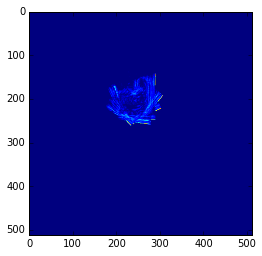

In [25]:
plt.imshow(exvol)

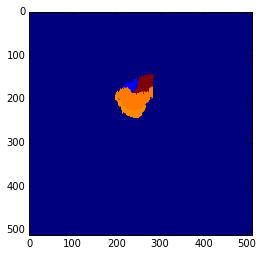

In [26]:
plt.imshow(exseg)

In [82]:
seed = np.random.randint(0, 2 ** 32 - 1)
randomizer = np.random.RandomState(seed)
shape = exvol.shape
rand_arr1 = randomizer.rand(*shape)
rand_arr2 = randomizer.rand(*shape)
deformedvol = elastic_transform(exvol, 5, 3, rand_arr1, rand_arr2)

ValueError: operands could not be broadcast together with shapes (512,512) (128,128) 

False
False


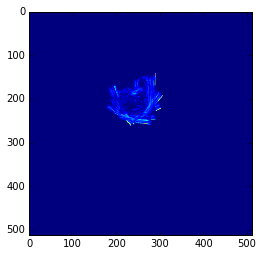

In [50]:
plt.imshow(deformedvol)
print(np.unique(exvol).shape == np.unique(deformedvol).shape)
print(np.all(exvol == deformedvol))

In [63]:
deformedseg = elastic_transform(exseg, 4, 30, rand_arr1, rand_arr2)

False
False


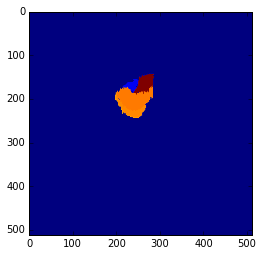

In [64]:
plt.imshow(deformedseg)
print(np.unique(exseg).shape == np.unique(deformedseg).shape)
print(np.all(exseg == deformedseg))

In [19]:
true_labels = np.unique(exseg)
print(true_labels)
deformedseg = spread_compress_labels(exseg, 'spread')
deformedseg = elastic_transform(deformedseg, 34, 3, rand_arr1, rand_arr2)
deformedseg = restore_valid_labels_subs(deformedseg, true_labels)
restored_deformedseg = spread_compress_labels(deformedseg, 'compress')

[ 0.  7. 52. 53. 68.]


True
(5,) (5,)
False
[ 0  7 52 53 68]


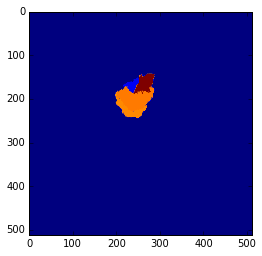

In [20]:
plt.imshow(restored_deformedseg)
print(np.unique(exseg).shape == np.unique(restored_deformedseg).shape)
print(np.unique(exseg).shape, np.unique(restored_deformedseg).shape)
print(np.all(exseg == restored_deformedseg))
print(np.unique(restored_deformedseg))

In [178]:
def elastic_transform_nifti_subs(nifti_vol_arr, nifti_seg_arr, alpha, sigma):
    transformed_vol_arr = np.empty(nifti_vol_arr.shape)
    transformed_seg_arr = np.empty(nifti_seg_arr.shape)
    seed = np.random.randint(0, 2 ** 32 - 1)
    randomizer = np.random.RandomState(seed)
    for i in range(nifti_vol_arr.shape[0]):
        print(i, end='; ')
        rand_arr1 = randomizer.rand(*nifti_vol_arr[i].shape)
        rand_arr2 = randomizer.rand(*nifti_vol_arr[i].shape)
        print("About to transform vol slice;", end=' ')
        transformed_vol_slice = elastic_transform(nifti_vol_arr[i], alpha, sigma, rand_arr1, rand_arr2, int_order=1)
        print("About to transform seg slice;", end=' ')
        transformed_seg_slice = elastic_transform(nifti_seg_arr[i], alpha, sigma, rand_arr1, rand_arr2, int_order=0)
        print("Done with transformations;", end=' ')
        transformed_vol_arr[i] = transformed_vol_slice
        transformed_seg_arr[i] = transformed_seg_slice
        print(' ')
    return transformed_vol_arr, transformed_seg_arr

transformed_vol_arr, transformed_seg_arr = elastic_transform_nifti_subs(nii_vol_arr, nii_seg_arr, 35, 3)

0; About to transform vol slice; About to transform seg slice; Done with transformations;  
1; About to transform vol slice; About to transform seg slice; Done with transformations;  
2; About to transform vol slice; About to transform seg slice; Done with transformations;  
3; About to transform vol slice; About to transform seg slice; Done with transformations;  
4; About to transform vol slice; About to transform seg slice; Done with transformations;  
5; About to transform vol slice; About to transform seg slice; Done with transformations;  
6; About to transform vol slice; About to transform seg slice; Done with transformations;  
7; About to transform vol slice; About to transform seg slice; Done with transformations;  
8; About to transform vol slice; About to transform seg slice; Done with transformations;  
9; About to transform vol slice; About to transform seg slice; Done with transformations;  
10; About to transform vol slice; About to transform seg slice; Done with transf

89; About to transform vol slice; About to transform seg slice; Done with transformations;  
90; About to transform vol slice; About to transform seg slice; Done with transformations;  
91; About to transform vol slice; About to transform seg slice; Done with transformations;  
92; About to transform vol slice; About to transform seg slice; Done with transformations;  
93; About to transform vol slice; About to transform seg slice; Done with transformations;  
94; About to transform vol slice; About to transform seg slice; Done with transformations;  
95; About to transform vol slice; About to transform seg slice; Done with transformations;  
96; About to transform vol slice; About to transform seg slice; Done with transformations;  
97; About to transform vol slice; About to transform seg slice; Done with transformations;  
98; About to transform vol slice; About to transform seg slice; Done with transformations;  
99; About to transform vol slice; About to transform seg slice; Done w

177; About to transform vol slice; About to transform seg slice; Done with transformations;  
178; About to transform vol slice; About to transform seg slice; Done with transformations;  
179; About to transform vol slice; About to transform seg slice; Done with transformations;  
180; About to transform vol slice; About to transform seg slice; Done with transformations;  
181; About to transform vol slice; About to transform seg slice; Done with transformations;  
182; About to transform vol slice; About to transform seg slice; Done with transformations;  
183; About to transform vol slice; About to transform seg slice; Done with transformations;  
184; About to transform vol slice; About to transform seg slice; Done with transformations;  
185; About to transform vol slice; About to transform seg slice; Done with transformations;  
186; About to transform vol slice; About to transform seg slice; Done with transformations;  
187; About to transform vol slice; About to transform seg sl

265; About to transform vol slice; About to transform seg slice; Done with transformations;  
266; About to transform vol slice; About to transform seg slice; Done with transformations;  
267; About to transform vol slice; About to transform seg slice; Done with transformations;  
268; About to transform vol slice; About to transform seg slice; Done with transformations;  
269; About to transform vol slice; About to transform seg slice; Done with transformations;  
270; About to transform vol slice; About to transform seg slice; Done with transformations;  
271; About to transform vol slice; About to transform seg slice; Done with transformations;  
272; About to transform vol slice; About to transform seg slice; Done with transformations;  
273; About to transform vol slice; About to transform seg slice; Done with transformations;  
274; About to transform vol slice; About to transform seg slice; Done with transformations;  
275; About to transform vol slice; About to transform seg sl

352; About to transform vol slice; About to transform seg slice; Done with transformations;  
353; About to transform vol slice; About to transform seg slice; Done with transformations;  
354; About to transform vol slice; About to transform seg slice; Done with transformations;  
355; About to transform vol slice; About to transform seg slice; Done with transformations;  
356; About to transform vol slice; About to transform seg slice; Done with transformations;  
357; About to transform vol slice; About to transform seg slice; Done with transformations;  
358; About to transform vol slice; About to transform seg slice; Done with transformations;  
359; About to transform vol slice; About to transform seg slice; Done with transformations;  
360; About to transform vol slice; About to transform seg slice; Done with transformations;  
361; About to transform vol slice; About to transform seg slice; Done with transformations;  
362; About to transform vol slice; About to transform seg sl

439; About to transform vol slice; About to transform seg slice; Done with transformations;  
440; About to transform vol slice; About to transform seg slice; Done with transformations;  
441; About to transform vol slice; About to transform seg slice; Done with transformations;  
442; About to transform vol slice; About to transform seg slice; Done with transformations;  
443; About to transform vol slice; About to transform seg slice; Done with transformations;  
444; About to transform vol slice; About to transform seg slice; Done with transformations;  
445; About to transform vol slice; About to transform seg slice; Done with transformations;  
446; About to transform vol slice; About to transform seg slice; Done with transformations;  
447; About to transform vol slice; About to transform seg slice; Done with transformations;  
448; About to transform vol slice; About to transform seg slice; Done with transformations;  
449; About to transform vol slice; About to transform seg sl

526; About to transform vol slice; About to transform seg slice; Done with transformations;  
527; About to transform vol slice; About to transform seg slice; Done with transformations;  
528; About to transform vol slice; About to transform seg slice; Done with transformations;  
529; About to transform vol slice; About to transform seg slice; Done with transformations;  
530; About to transform vol slice; About to transform seg slice; Done with transformations;  
531; About to transform vol slice; About to transform seg slice; Done with transformations;  
532; About to transform vol slice; About to transform seg slice; Done with transformations;  
533; About to transform vol slice; About to transform seg slice; Done with transformations;  
534; About to transform vol slice; About to transform seg slice; Done with transformations;  
535; About to transform vol slice; About to transform seg slice; Done with transformations;  
536; About to transform vol slice; About to transform seg sl

613; About to transform vol slice; About to transform seg slice; Done with transformations;  
614; About to transform vol slice; About to transform seg slice; Done with transformations;  
615; About to transform vol slice; About to transform seg slice; Done with transformations;  
616; About to transform vol slice; About to transform seg slice; Done with transformations;  
617; About to transform vol slice; About to transform seg slice; Done with transformations;  
618; About to transform vol slice; About to transform seg slice; Done with transformations;  
619; About to transform vol slice; About to transform seg slice; Done with transformations;  
620; About to transform vol slice; About to transform seg slice; Done with transformations;  
621; About to transform vol slice; About to transform seg slice; Done with transformations;  
622; About to transform vol slice; About to transform seg slice; Done with transformations;  
623; About to transform vol slice; About to transform seg sl

700; About to transform vol slice; About to transform seg slice; Done with transformations;  
701; About to transform vol slice; About to transform seg slice; Done with transformations;  
702; About to transform vol slice; About to transform seg slice; Done with transformations;  
703; About to transform vol slice; About to transform seg slice; Done with transformations;  
704; About to transform vol slice; About to transform seg slice; Done with transformations;  
705; About to transform vol slice; About to transform seg slice; Done with transformations;  
706; About to transform vol slice; About to transform seg slice; Done with transformations;  
707; About to transform vol slice; About to transform seg slice; Done with transformations;  
708; About to transform vol slice; About to transform seg slice; Done with transformations;  
709; About to transform vol slice; About to transform seg slice; Done with transformations;  
710; About to transform vol slice; About to transform seg sl

787; About to transform vol slice; About to transform seg slice; Done with transformations;  
788; About to transform vol slice; About to transform seg slice; Done with transformations;  
789; About to transform vol slice; About to transform seg slice; Done with transformations;  
790; About to transform vol slice; About to transform seg slice; Done with transformations;  
791; About to transform vol slice; About to transform seg slice; Done with transformations;  
792; About to transform vol slice; About to transform seg slice; Done with transformations;  
793; About to transform vol slice; About to transform seg slice; Done with transformations;  
794; About to transform vol slice; About to transform seg slice; Done with transformations;  
795; About to transform vol slice; About to transform seg slice; Done with transformations;  
796; About to transform vol slice; About to transform seg slice; Done with transformations;  
797; About to transform vol slice; About to transform seg sl

875; About to transform vol slice; About to transform seg slice; Done with transformations;  
876; About to transform vol slice; About to transform seg slice; Done with transformations;  
877; About to transform vol slice; About to transform seg slice; Done with transformations;  
878; About to transform vol slice; About to transform seg slice; Done with transformations;  
879; About to transform vol slice; About to transform seg slice; Done with transformations;  
880; About to transform vol slice; About to transform seg slice; Done with transformations;  
881; About to transform vol slice; About to transform seg slice; Done with transformations;  
882; About to transform vol slice; About to transform seg slice; Done with transformations;  
883; About to transform vol slice; About to transform seg slice; Done with transformations;  
884; About to transform vol slice; About to transform seg slice; Done with transformations;  
885; About to transform vol slice; About to transform seg sl

962; About to transform vol slice; About to transform seg slice; Done with transformations;  
963; About to transform vol slice; About to transform seg slice; Done with transformations;  
964; About to transform vol slice; About to transform seg slice; Done with transformations;  
965; About to transform vol slice; About to transform seg slice; Done with transformations;  
966; About to transform vol slice; About to transform seg slice; Done with transformations;  
967; About to transform vol slice; About to transform seg slice; Done with transformations;  
968; About to transform vol slice; About to transform seg slice; Done with transformations;  
969; About to transform vol slice; About to transform seg slice; Done with transformations;  
970; About to transform vol slice; About to transform seg slice; Done with transformations;  
971; About to transform vol slice; About to transform seg slice; Done with transformations;  
972; About to transform vol slice; About to transform seg sl

In [ ]:
def elastic_transform_nifti(nifti_vol_arr, nifti_seg_arr, alpha, sigma):
    transformed_vol_arr = np.empty(nifti_vol_arr.shape)
    transformed_seg_arr = np.empty(nifti_seg_arr.shape)
    seed = np.random.randint(0, 2 ** 32 - 1)
    randomizer = np.random.RandomState(seed)
    for i in range(nifti_vol_arr.shape[0]):
        print(i, end='; ')
        rand_arr1 = randomizer.rand(*nifti_vol_arr[i].shape)
        rand_arr2 = randomizer.rand(*nifti_vol_arr[i].shape)
        print("About to transform vol slice;", end=' ')
        transformed_vol_slice = elastic_transform(nifti_vol_arr[i], alpha, sigma, rand_arr1, rand_arr2)
        print("About to transform seg slice;", end=' ')
        true_orig_labels = np.unique(nifti_seg_arr[i])
        transformed_seg_slice = nifti_seg_arr[i] * 10
        transformed_seg_slice = elastic_transform(transformed_seg_slice, alpha, sigma, rand_arr1, rand_arr2)
        transformed_seg_slice = restore_valid_labels(transformed_seg_slice, true_orig_labels)
        print("Done with transformations;", end=' ')
        transformed_vol_arr[i] = transformed_vol_slice
        transformed_seg_arr[i] = transformed_seg_slice
        print(' ')
    return transformed_vol_arr, transformed_seg_arr

transformed_vol_arr, transformed_seg_arr = elastic_transform_nifti(nii_vol_arr, nii_seg_arr, 34, 10)

In [175]:
nii_save_dir = "/Users/nozik/Documents/HARTresearch/augmented_data/elastic_transformed_nii"

In [179]:
pipeline.save_arr_as_nifti(transformed_vol_arr, nii_vol_name, "trial8_30_fs_vol_elast_fixed_a35_s3.nii", nii_data_dir, nii_save_dir)
pipeline.save_arr_as_nifti(transformed_seg_arr, nii_seg_name, "trial8_30_fs_seg_elast_fixed_a35_s3.nii", nii_data_dir, nii_save_dir)

In [ ]:
np.unique(transformed_seg_arr).shape

In [ ]:
np.unique(nii_seg_arr).shape

In [72]:
def bounding_box(img):
    """
    Returns copy of the img bounded by the box from the image.
    """

    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    box = img[rmin : rmax, cmin : cmax]
    return box

In [79]:
cropped = bounding_box(exseg)
padded = pipeline.pad_image(cropped, 128, 128)

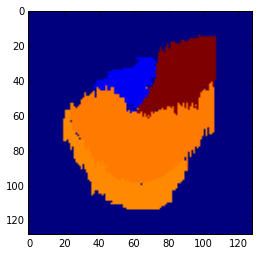

In [80]:
plt.imshow(padded)

In [83]:
seed = np.random.randint(0, 2 ** 32 - 1)
randomizer = np.random.RandomState(seed)
shape = padded.shape
rand_arr1 = randomizer.rand(*shape)
rand_arr2 = randomizer.rand(*shape)

In [122]:
def nearest_neighbors_restore(to_restore):
    restored = np.empty_like(to_restore)
    for i in range(1, to_restore.shape[0] - 1):
        for j in range(1, to_restore.shape[1] - 1):
            neighbors = []
            # labels = np.unique(original)
            # if j > 0:
            neighbors.append(to_restore[i][j - 1])
                # count += 1
            # if i > 0:
            neighbors.append(to_restore[i - 1][j])
                # count += 1
            # if i < to_restore.shape[1] - 1:
            neighbors.append(to_restore[i + 1][j])
                # count += 1
            # if j < to_restore.shape[0] - 1:
            neighbors.append(to_restore[i][j + 1])
            restored[i][j] = max(set(neighbors), key=neighbors.count)
    return restored

In [ ]:
def elastic_transform_all(source_data_dir, nii_data_dir, nii_save_dir):
    alphas = [10, 20, 35]
    sigmas = [3, 5, 8, 10, 12]
    for folder in os.listdir(source_data_dir):
        files = {}
        for file in os.listdir(os.path.join(source_data_dir, folder)):
            if 'seg' in file:
                files['seg'] = file
            elif 'vol' in file:
                files['volume'] = file
        
        vol_path = os.path.join(os.path.join(source_data_dir, folder), files['vol'])
        nii_vol = nib.load(vol_path)
        nii_vol_arr = nii_vol.get_fdata()
        seg_path = os.path.join(os.path.join(source_data_dir, folder), files['seg'])
        nii_seg = nib.load(seg_path)
        nii_seg_arr = nii_seg.get_fdata()
        
        vol_base_name = files['volume'].split(".nii")[0]
        seg_base_name = files['seg'].split(".nii")[0]
        
        for alpha in alphas:
            for sigma in sigmas:
                transformed_vol_arr, transformed_seg_arr = elastic_transform_nifti_subs(nii_vol_arr, 
                                                                                        nii_seg_arr,
                                                                                        alpha,
                                                                                        sigma)
                new_vol_name = vol_base_name + "_elastic_a" + alpha + "_s" + sigma + ".nii"
                new_seg_name = vol_base_name + "_elastic_a" + alpha + "_s" + sigma + ".nii"
                pipeline.save_arr_as_nifti(transformed_vol_arr, files['volume'], new_vol_name, nii_data_dir, nii_save_dir)
                pipeline.save_arr_as_nifti(transformed_seg_arr, files['seg'], new_seg_name, nii_data_dir, nii_save_dir)
                
        
        
        
            
        

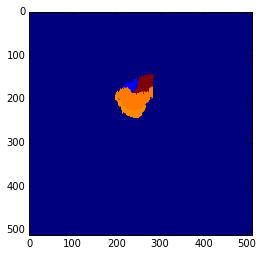

In [15]:
plt.imshow(exseg)

0 1 2 3 4 5 6 7 8 9 

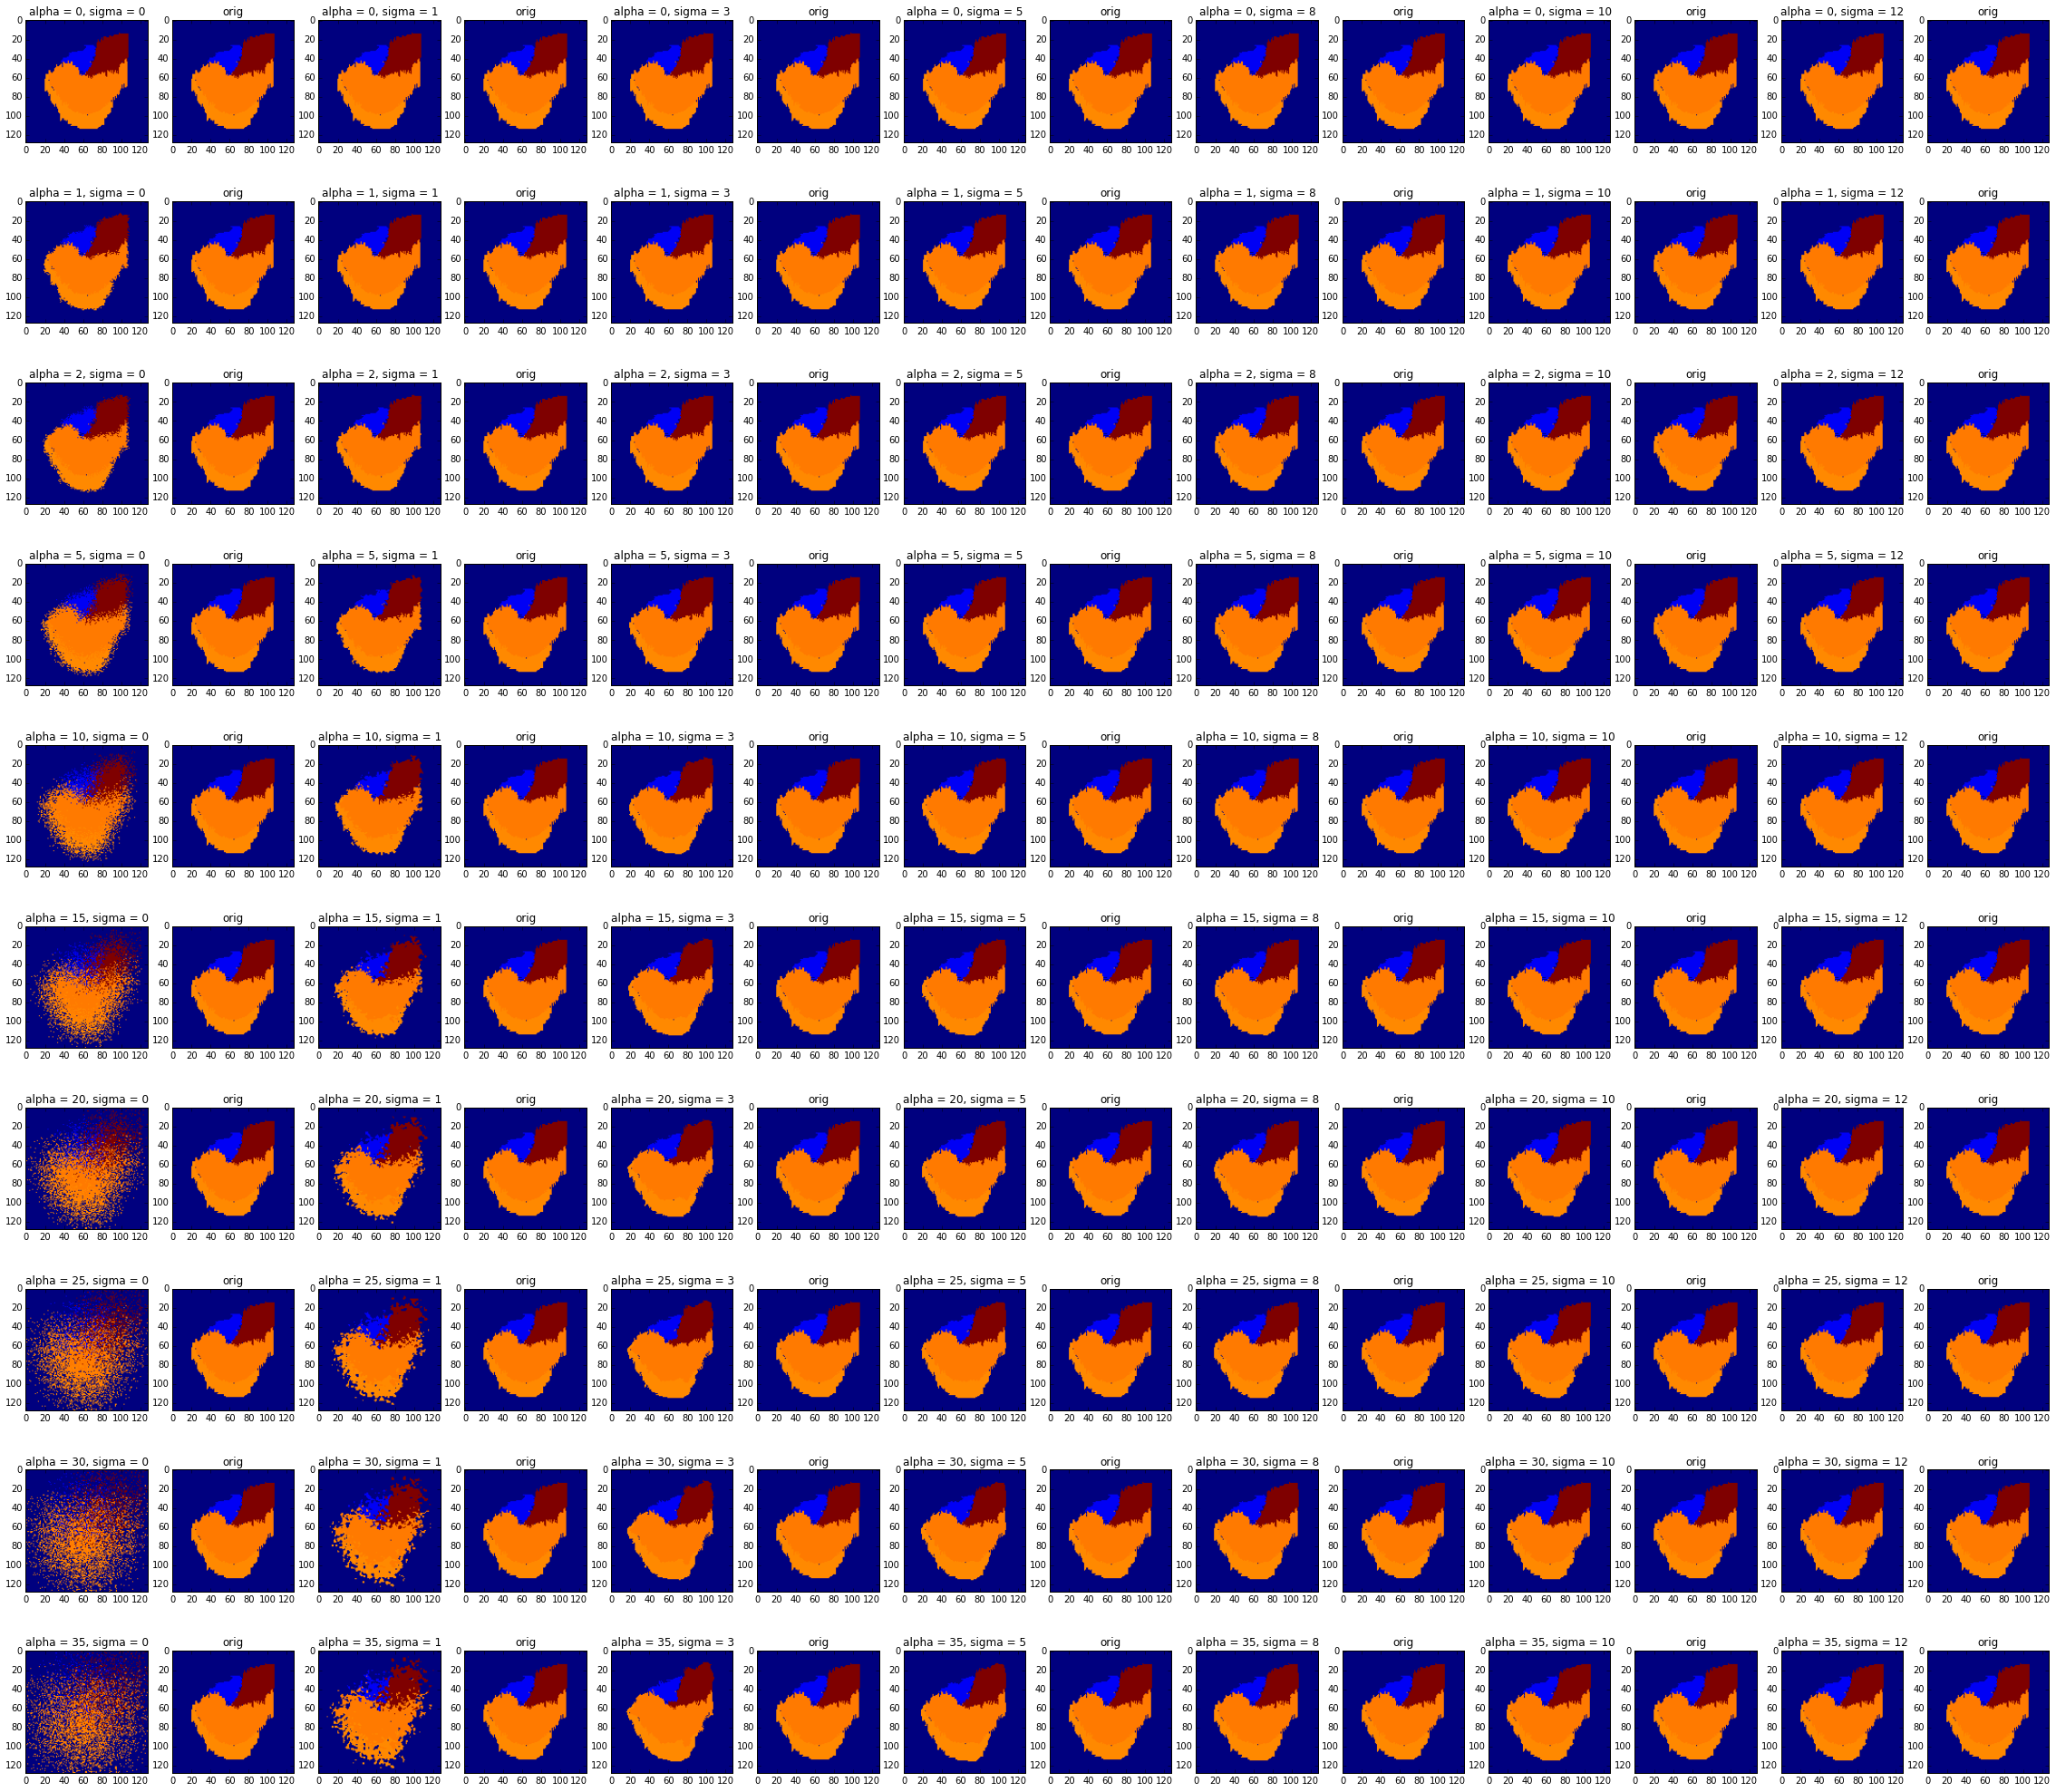

In [170]:
height, width = 10, 7

alphas = [0, 1, 2, 5, 10, 15, 20, 25, 30, 35]
sigmas = [0, 1, 3, 5, 8, 10, 12]

true_orig_labels = np.unique(padded)
spreaded = spread_compress_labels(padded, 'spread')

f, axarr = plt.subplots(len(alphas),len(sigmas) * 2)
f.set_size_inches(40,35)
for i in range(len(alphas)):
    print(i, end=' ')
    for j in range(len(sigmas)):
        img = elastic_transform(padded, alphas[i], sigmas[j], rand_arr1, rand_arr2, 0)
        #img = restore_valid_labels_subs(img, true_orig_labels)
        #img = spread_compress_labels(img, 'compress')
        #img = nearest_neighbors_restore(img)
        #img = nearest_neighbors_restore(img)
        title = 'alpha = ' + str(alphas[i]) + ', sigma = ' + str(sigmas[j])
        axarr[i, j * 2].set_title(title)
        axarr[i, j * 2].imshow(img)
        axarr[i, j * 2 + 1].imshow(padded)
        axarr[i, j * 2 + 1].set_title('orig')
        

f.subplots_adjust(hspace=0.3)
f.patch.set_facecolor('white')